### Import libs and datasets

In [147]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [148]:
pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)

In [149]:
ross_df  = pd.read_csv('./dataset/rossmann_store/train.csv', low_memory=False)
test_df  = pd.read_csv('./dataset/rossmann_store/test.csv')
store_df = pd.read_csv('./dataset/rossmann_store/store.csv')
submission_df  = pd.read_csv('./dataset/rossmann_store/sample_submission.csv')

In [150]:
merged_df = ross_df.merge(store_df, how='left', on='Store')
merged_test_df = test_df.merge(store_df, how='left', on='Store')

#### Date

In [151]:
def split_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.isocalendar().week

In [152]:
split_date(merged_df)
split_date(merged_test_df)

#### Open

Có thể nhận thấy, Sales = 0 đa phần do cột Open có giá trị = 0 (cửa hàng không mở cửa )

In [153]:
merged_df = merged_df[merged_df.Open == 1].copy()

In [154]:
merged_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31


#### Competition

Tiếp theo, chúng ta có thể sử dụng các cột `CompetitionOpenSince[Month/Year]` từ `store_df` để tính số tháng mà một đối thủ cạnh tranh đã mở cửa hàng gần đó.

In [155]:
def comp_months(df):
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)

In [156]:
comp_months(merged_df)
comp_months(merged_test_df)

In [157]:
merged_df.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31,82.0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,92.0


#### Additional Promotion (Promo2)

In [158]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [159]:
promo_cols(merged_df)
promo_cols(merged_test_df)

### Input and Target Columns

In [160]:
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
              'Day', 'Month', 'Year', 'WeekOfYear',  'Promo2', 
              'Promo2Open', 'IsPromo2Month']

target_col = 'Sales'

In [161]:
inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()

In [162]:
test_inputs = merged_test_df[input_cols].copy()

In [163]:
numeric_cols = ['Store', 'Promo', 'SchoolHoliday', 
              'CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month',
              'Day', 'Month', 'Year', 'WeekOfYear',  ]

categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

### Imputing missing data

In [164]:
inputs[numeric_cols].isna().sum()

Store                     0
Promo                     0
SchoolHoliday             0
CompetitionDistance    2186
CompetitionOpen           0
Promo2                    0
Promo2Open                0
IsPromo2Month             0
Day                       0
Month                     0
Year                      0
WeekOfYear                0
dtype: int64

In [165]:
test_inputs[numeric_cols].isna().sum()

Store                   0
Promo                   0
SchoolHoliday           0
CompetitionDistance    96
CompetitionOpen         0
Promo2                  0
Promo2Open              0
IsPromo2Month           0
Day                     0
Month                   0
Year                    0
WeekOfYear              0
dtype: int64

CompetitionDistance chứa 2186 training và 96 test missing values. 

Vì vậy, có thể fill giá trị blank này bằng giá trị max() của CompetitionDistance để nói rằng đối thủ "ở rất xa"

In [166]:
max_distance = inputs.CompetitionDistance.max()

In [167]:
inputs['CompetitionDistance'].fillna(max_distance, inplace=True)
test_inputs['CompetitionDistance'].fillna(max_distance, inplace=True)

C:\Users\TuNguyen\AppData\Local\Temp\ipykernel_8264\751725973.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  inputs['CompetitionDistance'].fillna(max_distance, inplace=True)
C:\Users\TuNguyen\AppData\Local\Temp\ipykernel_8264\751725973.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

### Scale numeric columns

In [168]:
from sklearn.preprocessing import MinMaxScaler

In [169]:
scaler = MinMaxScaler().fit(inputs[numeric_cols])

In [170]:
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

### Encode Categorical Columns

<img src="https://i.imgur.com/n8GuiOO.png" width="640">

In [171]:
from sklearn.preprocessing import OneHotEncoder

In [172]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

In [173]:
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

Combine for X_train , X_test

In [174]:
X_train = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [175]:
X_train

,Store,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,Day,Month,Year,WeekOfYear,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,0.000000,1.0,1.0,0.016482,0.059163,0.0,0.000000,0.0,1.0,0.545455,1.0,0.588235,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.000898,1.0,1.0,0.007252,0.066378,1.0,0.890710,1.0,1.0,0.545455,1.0,0.588235,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.001795,1.0,1.0,0.186050,0.074315,1.0,0.720856,1.0,1.0,0.545455,1.0,0.588235,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.002693,1.0,1.0,0.007911,0.050505,0.0,0.000000,0.0,1.0,0.545455,1.0,0.588235,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.003591,1.0,1.0,0.394119,0.002165,0.0,0.000000,0.0,1.0,0.545455,1.0,0.588235,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,0.611311,0.0,1.0,0.001714,0.054834,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1016827,0.657092,0.0,1.0,0.011076,0.114719,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1016863,0.689408,0.0,1.0,0.010812,0.000000,1.0,0.016849,1.0,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1017042,0.850090,0.0,1.0,0.018592,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### Gradient Boosting

Bây giờ chúng ta đã sẵn sàng để đào tạo mô hình máy tăng cường độ dốc (GBM) của mình. Sau đây là cách thức hoạt động của mô hình GBM:

1. Giá trị trung bình của cột target và sử dụng làm dự đoán ban đầu cho mọi đầu vào.

2. Tính toán các residual (phân dư) của các dự đoán với các mục tiêu.

3. Một cây quyết định có độ sâu hạn chế được đào tạo để **chỉ dự đoán các residuals** cho mỗi đầu vào.

4. Các dự đoán từ cây quyết định được chia tỷ lệ bằng cách sử dụng một tham số `learning_rate` (điều này ngăn chặn over-fit)

5. Các dự đoán được chia tỷ lệ cho cây được thêm vào các dự đoán trước đó để có được các dự đoán mới và được cải thiện.

6. Các bước từ 2 đến 5 được lặp lại để tạo ra các cây quyết định mới, mỗi cây được đào tạo để chỉ dự đoán các giá trị resid từ dự đoán trước đó.

Thuật ngữ "gradient" đề cập đến thực tế là mỗi cây quyết định được đào tạo với mục đích giảm tổn thất từ ​​lần lặp trước (tương tự như giảm độ dốc). 

Thuật ngữ "boosting" đề cập đến kỹ thuật chung để đào tạo các mô hình mới nhằm cải thiện kết quả của một mô hình hiện có.

Giải thích kĩ hơn về Gradient Boosting theo hướng toán học: 

- [XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)

- [Video Tutorials on StatQuest](https://www.youtube.com/watch?v=3CC4N4z3GJc&list=PLblh5JKOoLUJjeXUvUE0maghNuY2_5fY6)

Hình ảnh minh họa Gradient Boosting:

<img src= "https://pythongeeks.org/wp-content/uploads/2022/03/working-of-gradient-boosting-algorithm.webp" width= 600>


### Training

Train 1 `Gradient Boosting Machine`, sử dụng `XGBRegressor` từ [`XGBoost`](https://xgboost.readthedocs.io/en/latest/) library.

In [176]:
from xgboost import XGBRegressor

In [177]:
?XGBRegressor

Init signature:
XGBRegressor(
    *,
    objective: Union[str, xgboost.sklearn._SklObjWProto, Callable[[Any, Any], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = 'reg:squarederror',
    **kwargs: Any,
) -> None
Docstring:     
Implementation of the scikit-learn API for XGBoost regression.
See :doc:`/python/sklearn_estimator` for more information.

Parameters
----------

    n_estimators : typing.Optional[int]
        Number of gradient boosted trees.  Equivalent to number of boosting
        rounds.

    max_depth :  typing.Optional[int]

        Maximum tree depth for base learners.

    max_leaves : typing.Optional[int]

        Maximum number of leaves; 0 indicates no limit.

    max_bin : typing.Optional[int]

        If using histogram-based algorithm, maximum number of bins per feature

    grow_policy : typing.Optional[str]

        Tree growing policy.

        - depthwise: Favors splitting at nodes closest to the node,
        - lossguide: Favors splitting at nodes with hig

In [178]:
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)

In [179]:
%%time
model.fit(X_train, targets)

CPU times: total: 7.95 s
Wall time: 1.12 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

### Prediction

We can now make predictions and evaluate the model using `model.predict`.

In [180]:
preds = model.predict(X_train)
preds

array([ 7960.1133,  7581.974 ,  7993.401 , ...,  7101.1714,  8794.572 ,
       10820.442 ], dtype=float32)

### Evaluation

In [181]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error

In [182]:
rmse_xgb = root_mean_squared_error(preds, targets)
rmse_xgb

2397.1614431476673

### Visualization

In [183]:
import matplotlib.pyplot as plt
from xgboost import plot_tree
# from matplotlib.pylab import rcParams
%matplotlib inline

# rcParams['figure.figsize'] = 30,30

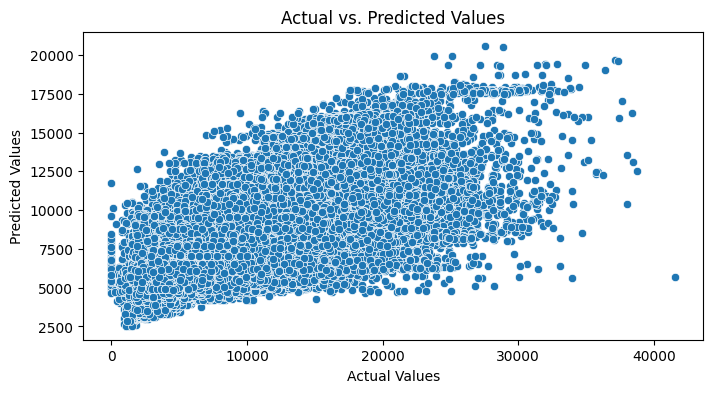

In [184]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of actual vs. predicted values
plt.figure(figsize= (8, 4))
sns.scatterplot(x=targets, y=preds)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

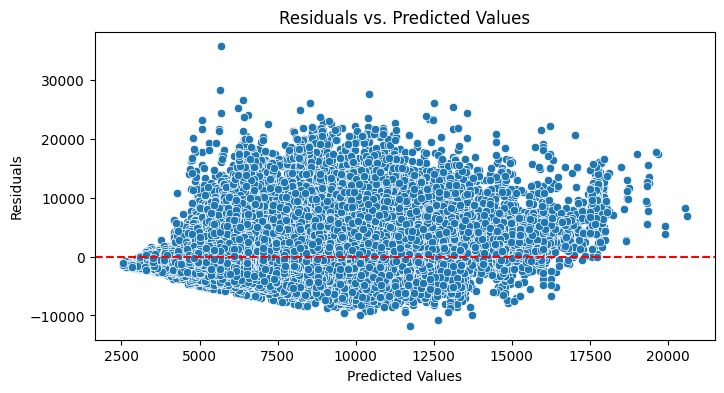

In [185]:
# Residual plot (actual - predicted)
residuals = targets - preds

plt.figure(figsize=(8, 4))
sns.scatterplot(x=preds, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

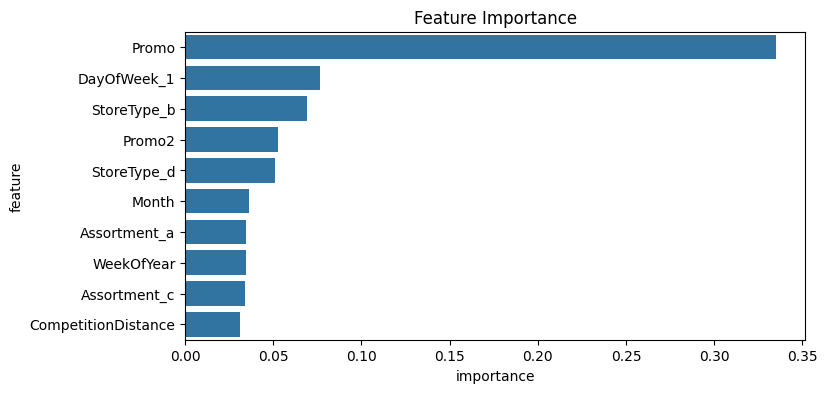

In [186]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

import seaborn as sns
plt.figure(figsize=(8,4))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

In [187]:
trees = model.get_booster().get_dump()
len(trees)

20

In [188]:
print(trees[0])

0:[Promo<1] yes=1,no=2,missing=2
	1:[StoreType_b<1] yes=3,no=4,missing=4
		3:[Assortment_a<1] yes=7,no=8,missing=8
			7:[CompetitionDistance<0.00448312238] yes=15,no=16,missing=16
				15:leaf=223.091629
				16:leaf=-263.189026
			8:[WeekOfYear<0.921568632] yes=17,no=18,missing=18
				17:leaf=-467.055237
				18:leaf=-83.930191
		4:[CompetitionDistance<0.015822785] yes=9,no=10,missing=10
			9:[CompetitionDistance<0.0117352316] yes=19,no=20,missing=20
				19:leaf=654.354065
				20:leaf=3492.14575
			10:[DayOfWeek_7<1] yes=21,no=22,missing=22
				21:leaf=-187.357132
				22:leaf=877.194702
	2:[DayOfWeek_1<1] yes=5,no=6,missing=6
		5:[Month<1] yes=11,no=12,missing=12
			11:[StoreType_b<1] yes=23,no=24,missing=24
				23:leaf=208.808884
				24:leaf=1208.23828
			12:[Day<0.200000003] yes=25,no=26,missing=26
				25:leaf=668.335449
				26:leaf=1160.14038
		6:[Month<1] yes=13,no=14,missing=14
			13:[CompetitionDistance<0.00276898732] yes=27,no=28,missing=28
				27:leaf=1261.60889
				28:leaf=752.9

## K Fold Cross Validation

Trong bài này chưa có tạo ra 1 validation set trước khi train model. 

Vì vậy cần 1 phương pháp tiếp cận để validate khác, ở đây sử dụng `K-fold` cross validation ([source](https://vitalflux.com/k-fold-cross-validation-python-example/)):

![](https://vitalflux.com/wp-content/uploads/2020/08/Screenshot-2020-08-15-at-11.13.53-AM.png)

In [189]:
from sklearn.model_selection import KFold

In [190]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_rmse = root_mean_squared_error(model.predict(X_train), train_targets)
    val_rmse = root_mean_squared_error(model.predict(X_val), val_targets)
    return model, train_rmse, val_rmse

In [191]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
kfold

KFold(n_splits=5, random_state=42, shuffle=True)

In [192]:
models = []

for train_idxs, val_idxs in kfold.split(X_train):
    # Chia dữ liệu thành dữ liệu train và dữ liệu validation
    X_train_fold, train_targets_fold = X_train.iloc[train_idxs], targets.iloc[train_idxs]
    X_val_fold, val_targets_fold = X_train.iloc[val_idxs], targets.iloc[val_idxs]
    
    # Huấn luyện và đánh giá mô hình
    model, train_rmse, val_rmse = train_and_evaluate(
        X_train_fold, 
        train_targets_fold, 
        X_val_fold, 
        val_targets_fold, 
        max_depth=4, 
        n_estimators=20
    )
    
    models.append(model)
    print(f'Train RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}')

Train RMSE: 2385.4182, Validation RMSE: 2383.0556
Train RMSE: 2356.0484, Validation RMSE: 2358.1191
Train RMSE: 2360.6420, Validation RMSE: 2364.5161
Train RMSE: 2380.3926, Validation RMSE: 2387.6283
Train RMSE: 2392.4489, Validation RMSE: 2394.5807


In [193]:
import numpy as np

def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [196]:
preds = predict_avg(models, X_train)

In [195]:
preds

array([ 7939.758 ,  7470.379 ,  8586.605 , ...,  7225.786 ,  7965.5107,
       10251.975 ], dtype=float32)

## Hyperparameter Tuning and Regularization

Như các model khác, XGB có nhiều hyperparams để tuning

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

Check out the following resources to learn more about hyperparameter supported by XGBoost:

- https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
- https://xgboost.readthedocs.io/en/latest/parameter.html

In [197]:
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [198]:
def test_params_kfold(n_splits, **params):
    train_rmses, val_rmses, models = [], [], []
    kfold = KFold(n_splits)
    for train_idxs, val_idxs in kfold.split(X):
        X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
        X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
        model, train_rmse, val_rmse = train_and_evaluate(X_train, train_targets, X_val, val_targets, **params)
        models.append(model)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
    print('Train RMSE: {}, Validation RMSE: {}'.format(np.mean(train_rmses), np.mean(val_rmses)))
    return models

In [199]:
from sklearn.model_selection import train_test_split

In [200]:
X_train_new, X_val, train_targets, val_targets = train_test_split(X_train, targets, test_size=0.1)

In [203]:
def test_params(**params):
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(X_train_new, train_targets)
    train_rmse = root_mean_squared_error(model.predict(X_train_new), train_targets)
    val_rmse = root_mean_squared_error(model.predict(X_val), val_targets)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

#### `n_estimators`

Số lượng cây được tạo ra. Càng nhiều cây thì model càng mạnh

In [204]:
test_params(n_estimators=10)

Train RMSE: 2375.236832719292, Validation RMSE: 2389.9232655625065


In [205]:
test_params(n_estimators=250)

Train RMSE: 895.165999839707, Validation RMSE: 917.4663397053855


#### `max_depth`

Độ sâu của từng cây, độ sâu tăng thì cây càng mạnh

In [206]:
test_params(max_depth=2)

Train RMSE: 2385.231872200047, Validation RMSE: 2396.326513209378


In [207]:
test_params(max_depth=10)

Train RMSE: 670.809625782428, Validation RMSE: 773.3133869680948


#### `learning_rate`

Tốc độ học. Gần 0 ~ underfitting và gần ~ 1 overfitting

In [208]:
test_params(n_estimators=50, learning_rate=0.5)

Train RMSE: 1274.209370370351, Validation RMSE: 1293.4686953285018


In [209]:
test_params(n_estimators=50, learning_rate=0.9)

Train RMSE: 1135.28720321877, Validation RMSE: 1150.6588358688325


#### `booster`

Có 3 giá trị: 

- gblinear: linear models

- gbtree: decision trees

- dart: idk, nhưng rất lâu

In [210]:
test_params(booster='gblinear')

Train RMSE: 2724.3467156786583, Validation RMSE: 2742.1529868580838


In [212]:
test_params(booster='gbtree')

Train RMSE: 1159.1139407536243, Validation RMSE: 1175.3647670894175


In [ ]:
# test_params(booster='dart') #TOO SLOW :)

## Summary and References

<img src="https://media.licdn.com/dms/image/D4D12AQFPU4tS_Nw7Hg/article-cover_image-shrink_600_2000/0/1690693369312?e=2147483647&v=beta&t=Wk3hOnXCTcI9f50DqypNwsLDEjPYMmp6S4eiG2321Uo" width= 540>

The following topics were covered in this tutorial:

- Downloading a real-world dataset from a Kaggle competition
- Performing feature engineering and prepare the dataset for training
- Training and interpreting a gradient boosting model using XGBoost
- Training with KFold cross validation and ensembling results
- Configuring the gradient boosting model and tuning hyperparamters

Check out these resources to learn more: 

- https://albertum.medium.com/l1-l2-regularization-in-xgboost-regression-7b2db08a59e0
- https://machinelearningmastery.com/evaluate-gradient-boosting-models-xgboost-python/
- https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
- https://xgboost.readthedocs.io/en/latest/parameter.html
- https://www.kaggle.com/xwxw2929/rossmann-sales-top1
- https://jovian.ai/aakashns/python-gradient-boosting-machines#C108

## Revision Questions
1.	What is a Gradient Boosting Machine (GBM) model?
2.	What does term ‘gradient’ refer to?
3.	What does term ‘boosting’ refer to?
4.	What are weights and bias?
5.	How to choose differentiate/choose numerical and categorical columns?
6.	Why do you scale numerical columns?
7.	Why do you encode categorical columns?
8.	What is rankdir in <code>plot_tree()</code>?
9.	What is the working of K-fold cross validation?
10.	How does gamma hyperparameter work?
11.	What is generalization?
12.	What is ensembling?
13.	What are the different ways to impute missing data?
14.	What are the advantages of XGBoost?
15.	What are the disadvantages of XGBoost?
16.	What are the data pre-processing steps for XGBoost?
17.	What is <code>rcParams</code>?
18.	What does <code>get_dump()</code> do?
19.	What is the difference between XGBoost and LightGBM?
20.	Is XGBoost faster than Random Forest? If so, why?